In [2]:
import pandas as pd
import seaborn as sns
import tensorflow
import cv2
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50,VGG16,VGG19
from tensorflow.keras.layers import Dense,Flatten,Input,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG, load_img
from tensorflow.keras import layers,models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SeparableConv2D,BatchNormalization,GlobalAveragePooling2D,MaxPooling2D,concatenate, Conv2DTranspose,Conv2D
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [3]:
vgg=load_model("D:/Project/DL_project/vgg.keras")

In [4]:
class GradCAM:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name
        self.grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
        
    def generate(self, image_array, class_idx):
        with tf.GradientTape() as tape:
            conv_outputs, predictions = self.grad_model(image_array)
            loss = predictions[:, class_idx]

        output = conv_outputs[0]
        grads = tape.gradient(loss, conv_outputs)[0]
        

        guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

        weights = tf.reduce_mean(guided_grads, axis=(0, 1))

        cam = tf.reduce_sum(tf.multiply(weights, output), axis=-1)
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (image_array.shape[2], image_array.shape[1]))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

1/1 [==============================] - 0s 90ms/step
[[9.997712e-01 2.288202e-04 6.284805e-11 2.221481e-11]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


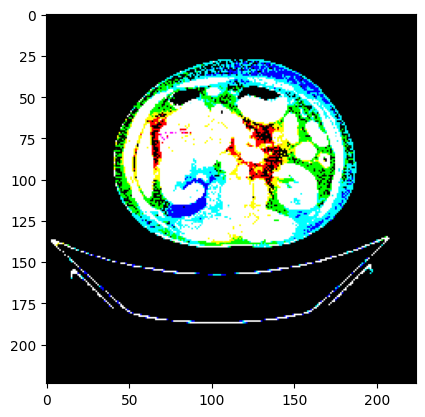

True

In [11]:
# Load and preprocess image
img_path = "D:/Datasets/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor\Tumor- (40).jpg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print(vgg.predict(x))
# Initialize GradCAM
gradcam = GradCAM(vgg, 'block5_conv1')

# Generate GradCAM heatmap
class_idx = 0  # Specify the class index (0-999 for ImageNet)
heatmap = gradcam.generate(x, class_idx)

# Superimpose heatmap on the original image
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + cv2.cvtColor(x[0], cv2.COLOR_RGB2BGR)
plt.imshow(superimposed_img, cmap="jet")
plt.show()
cv2.imwrite('D:/Datasets/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/gradcam_normal.jpg', superimposed_img)

In [6]:
def guided_relu(x):
    def grad(dy):
        return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy
    return tf.nn.relu(x), grad

In [7]:
for layer in vgg.layers:
    if isinstance(layer, tf.keras.layers.ReLU):
        layer.activation = guided_relu

In [8]:
def get_gradcam(input_model, image, layer_name):
    grad_model = tf.keras.models.Model([input_model.inputs], [input_model.get_layer(layer_name).output, input_model.output])
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(image)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_output)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]
    guided_grads = conv_output * pooled_grads[..., tf.newaxis]
    return guided_grads, class_idx

def guided_grad_cam(input_model, image, layer_name):
    guided_grads, class_idx = get_gradcam(input_model, image, layer_name)
    cam = tf.reduce_sum(guided_grads, axis=-1)
    return cam, class_idx

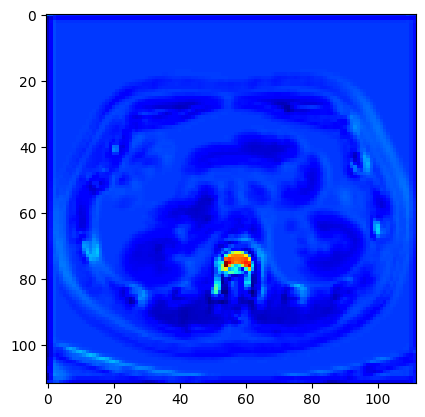

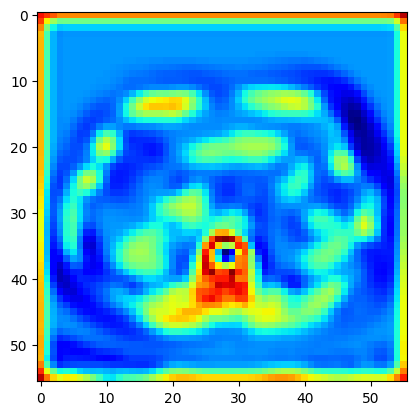

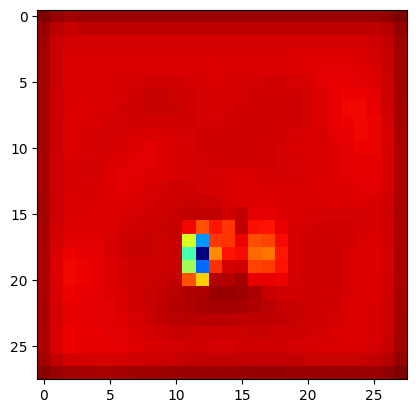

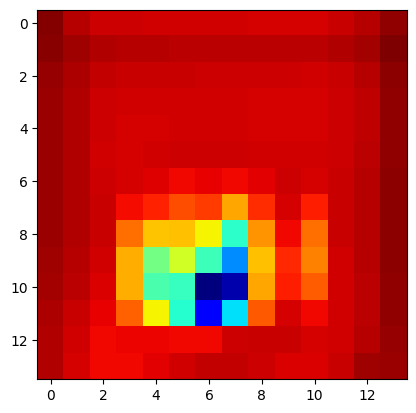

In [15]:
img = image.load_img(r"D:\Datasets\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\Cyst\Cyst- (26).jpg")  # Load your example image here
img=img.resize((224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
cam, class_idx = guided_grad_cam(vgg, x, "block2_conv2")
# Visualize the Guided Grad-CAM
plt.imshow(cam, cmap="jet")
plt.show()
cam, class_idx = guided_grad_cam(vgg, x, "block3_conv2")
# Visualize the Guided Grad-CAM
plt.imshow(cam, cmap="jet")
plt.show()
cam, class_idx = guided_grad_cam(vgg, x, "block4_conv2")
# Visualize the Guided Grad-CAM
plt.imshow(cam, cmap="jet")
plt.show()
cam, class_idx = guided_grad_cam(vgg, x, "block5_conv2")
# Visualize the Guided Grad-CAM
plt.imshow(cam, cmap="jet")
plt.show()
#plt.savefig("D:\Datasets\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\guided_stone.jpg")